# Customized Merging of Superpixels
In this notebook, we'll attempt to merge superpixels based on the methodology from the [image subregion detector](https://github.com/whitews/image-subregion-detector).

In [4]:
import os
import cv2
import numpy as np
from scipy.misc import imread
import matplotlib.pyplot as plt

from skimage import data, io, color, segmentation, exposure, measure, morphology
from skimage.segmentation import felzenszwalb, slic, quickshift, random_walker
from skimage.segmentation import mark_boundaries
from skimage.future import graph
import utils
%matplotlib inline

In [3]:
#image_subregion_detector takes RGB as input
image = imread('./2015-04-029_20X_C57Bl6_E16.5_LMM.14.24.4.46_SOX9_SFTPC_ACTA2_001.tif')
im1 = image[1000:1500, 1000:1500]

In this next step, we'll show the subset of the image we'll work with and also a segmentation according to sklearn.slic.

Number of segments: 511


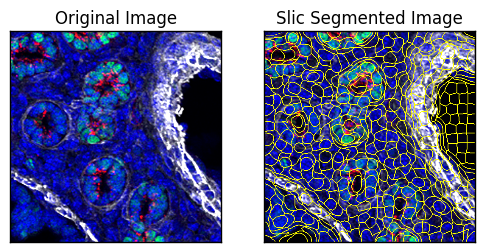

In [5]:
w, h, d = im1.shape
cell_area = 500
n_segments = int(w*h/cell_area)
segments = slic(im1, n_segments=n_segments, compactness=10, sigma=10, 
                multichannel=True, convert2lab=True)
print("Number of segments: %d" % len(np.unique(segments)))

plt.subplot(121),plt.imshow(im1)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(mark_boundaries(im1, segments))
plt.title('Slic Segmented Image'), plt.xticks([]), plt.yticks([])
plt.show()


## Restate Goal
Again, out goal is to merge these segments in such a way as to isolate "candidate" regions of interest (ROI) to submit to our ML algorithm. I see this as a two prong approach:

1. How do we isolate each segment to send to image_subregion_dectector to get meaninful metrics back?
2. How do we identify a ROI neighbors to determine merging criteria?

### Isolating each superpixel
This next section contains instructions for isolating superpixels. From above, we can tell there are 511 segments, I will randomly select one of them to illustrate integration with image_subregion_detector.py

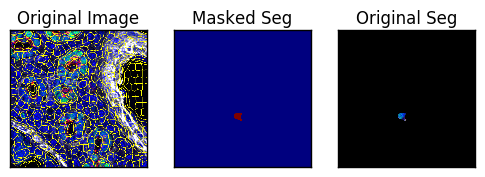

In [14]:
segVal=325    
mask = np.zeros(im1.shape[:2], dtype = "uint8")
mask[segments == segVal] = 255
region = cv2.bitwise_and(im1, im1, mask = mask)

plt.subplot(131),plt.imshow(mark_boundaries(im1, segments))
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(mask)
plt.title('Masked Seg'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(region)
plt.title('Original Seg'), plt.xticks([]), plt.yticks([])
plt.show()

> #### Thoughts
Now, we'd like to utilize the image_subregion_detector api to begin to get metrics on this segment of the picture, so that we can compare it to the neighbors.

In [15]:
target = cv2.cvtColor(np.array(region), cv2.COLOR_RGB2HSV)
color_profile = utils.get_color_profile(target)
color_profile

{'black': 249336,
 'blue': 495,
 'cyan': 137,
 'gray': 4,
 'green': 1,
 'red': 10,
 'violet': 17,
 'white': 0,
 'yellow': 0}

As you can see the majority of the picture is black, this is to be expected given the way we submitted information to the function; however, we'll need to modify this approach in the future. For now, let's just see, can we find this segment's neighbors and plot?

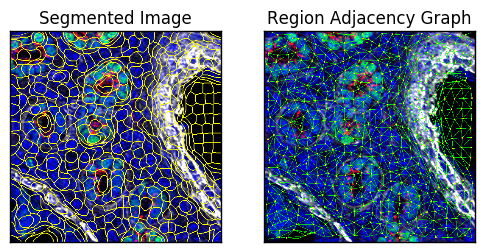

In [16]:
g = graph.rag_mean_color(im1, segments)
out = graph.draw_rag(segments, g, im1)


plt.subplot(121),plt.imshow(mark_boundaries(im1, segments))
plt.title('Segmented Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(out)
plt.title('Region Adjacency Graph'), plt.xticks([]), plt.yticks([])
plt.show()